# Tasks

1) Conduct exploratory analysis. Include whatever plots / distributions / text you want, but make sure you explain and write down the things that you've noticed.

2) How volatile are the individual contracts over time? Is there a pattern? Are there some useful features one could construct from relationships between the contracts?

3) Build a classification/regression (your choice) model. You can experiment with the target variable, but direction/magnitude of a **future** daily return is one of many perfectly acceptable options.

4) Evaluate the model using standard metrics. Does the model generalize?

5) Calculate and plot the maximum drawdown of the model on a hold-out set.

6) Calculate annualized sharpe ratio of the model (for simplicity assume benchmark rate =  0).


In [ ]:
pip install --upgrade matplotlib


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


ts = pd.read_csv("dataset.csv")

ts['Date'] = pd.to_datetime(ts['Date'])

ts['Year'] = ts['Date'].dt.year
ts['Month'] = ts['Date'].dt.month
ts['Weekday'] = ts['Date'].dt.dayofweek

ts.head()

,Date,Contract1,Contract2,Contract3,Contract4,Contract5,DailyReturn,Year,Month,Weekday
0,2000-01-04,50.73,52.12,53.48,54.80,55.20,NaN,2000,1,1
1,2000-01-05,51.56,52.83,54.10,55.70,56.10,0.016361,2000,1,2
2,2000-01-06,52.08,53.36,54.70,56.10,56.58,0.010085,2000,1,3
3,2000-01-07,53.96,55.09,56.37,57.95,58.42,0.036098,2000,1,4
4,2000-01-10,53.56,54.87,56.10,57.75,58.20,-0.007413,2000,1,0


In [ ]:
ts.isna().sum()


,0
Date,0
Contract1,0
Contract2,0
Contract3,1
Contract4,1
Contract5,6
DailyReturn,1
Year,0
Month,0
Weekday,0


# Impute missing values in a time-series dataset using the mean growth rate approach.

Firstly, we identify rows with NA values to check which of the columns contain NA's. After checking, knowing that this column does not contain NA values, we can calculate the growth rate for this column without NA as a ratio in time $t$ and $t-1$.

After calculating the growth rates for all such columns, we calculate the average of these growth rates. Finally, we multiply the last available value by this mean.



In [ ]:
def impute_with_growth_rate(df):

    df = df.copy()  # Avoid modifying the original DataFrame
    for col in df.columns:
        # Find rows with missing values in the current column
        missing_indices = df[df[col].isna()].index

        for idx in missing_indices:
            # Check which columns do not have NA in this row
            available_columns = df.loc[idx].dropna().index

            # Calculate growth rates for available columns
            growth_rates = []
            for available_col in available_columns:
                if idx > 0:  # Ensure there is a previous row to calculate growth rate
                    prev_value = df.loc[idx - 1, available_col]
                    curr_value = df.loc[idx, available_col]

                    if not pd.isna(prev_value) and not pd.isna(curr_value):
                        growth_rate = curr_value / prev_value
                        growth_rates.append(growth_rate)

            # Impute missing value using the mean growth rate
            if growth_rates:
                mean_growth_rate = np.mean(growth_rates)
                last_available_value = df.loc[idx - 1, col]

                if not pd.isna(last_available_value):  # Ensure the last value is valid
                    imputed_value = last_available_value * mean_growth_rate
                    df.loc[idx, col] = imputed_value

    return df



imputed_data = impute_with_growth_rate(ts[['Contract1', 'Contract2', 'Contract3', 'Contract4', 'Contract5']])

# Recombine the Date column with the imputed data
ts = pd.concat([ts[['Date', 'Year', 'Month', 'Weekday','DailyReturn']], imputed_data], axis=1)


ts.isna().sum()

,0
Date,0
Year,0
Month,0
Weekday,0
DailyReturn,1
Contract1,0
Contract2,0
Contract3,0
Contract4,0
Contract5,0


# Exploratory analysis and volatility of contracts

## Mean and Standard Deviation Analysis:

   The mean values across contracts suggest that they are closely related, indicating similar expected performance. However, the increase in standard deviation from the first to the fifth contract indicates a shift in risk profile. A higher standard deviation suggests more variability in returns, which actually implies that the fifth contract, despite its greater mean, might be less risky in terms of consistent performance compared to the first contract, which indicates higher volatility.

## Non-Parametric Statistics:

   Observing the quartiles' behavior is significant. The increasing of the first two quartiles implies that the lower half of contract prices is rising. However, the decline in the third quartile indicates that while lower-end outcomes are improving, high-end outcomes are not keeping pace. This can influence risk perception, as the potential for poor outcomes (worst-case scenarios) is higher in the fifth contract, despite its overall better performance in lower ranges.

## Skewness Assessment:

   The highest skewness of the first contract suggests the returns are not symmetrically distributed. A leftward bias implies more frequent lower returns with a potential for larger, less common higher returns. As skewness decreases in subsequent contracts, moving toward $0.64$ in the fifth, this signifies a move toward a more even distribution of risks and returns, reflecting greater stability in expected outcomes.

## Kurtosis Interpretation:

   Kurtosis impacts how concentrated values are around the mean. A higher kurtosis means that a larger portion of values is clustered near the average, implying reduced risk in extreme outcomes. This characteristic can be beneficial for investors as less pronounced tails mean fewer extreme losses or gains—essentially portraying more predictable performance.

## Conclusion and Financial Implications:

   Overall, while the fifth contract demonstrates decreasing skewness and potentially lower risk due to better stability in returns, the nuances in quartiles and higher kurtosis may provide insights into the overall strategy, But we'll look into it in the next chapter. From a financial standpoint, these metrics suggest that while higher average returns can be appealing, understanding the distribution characteristics is vital in assessing true risk, especially for investment decisions. The trade-off involves weighing potential higher extreme outcomes against the probability and costs associated with varying degrees of risk in each contract.

In [ ]:
describe_df = ts[['Contract1', 'Contract2', 'Contract3', 'Contract4', 'Contract5']].describe()

# Step 2: Calculate skewness and kurtosis
skewness = skew(ts[['Contract1', 'Contract2', 'Contract3', 'Contract4', 'Contract5']], axis=0)
kurt = kurtosis(ts[['Contract1', 'Contract2', 'Contract3', 'Contract4', 'Contract5']], axis=0)

# Step 3: Convert skewness and kurtosis to DataFrame
skew_df = pd.DataFrame([skewness], columns=describe_df.columns, index=['Skewness'])
kurt_df = pd.DataFrame([kurt], columns=describe_df.columns, index=['Kurtosis'])

# Step 4: Concatenate all data
result_df = pd.DataFrame(pd.concat([describe_df, skew_df, kurt_df]))

round(result_df,3)


,Contract1,Contract2,Contract3,Contract4,Contract5
count,6255.000,6255.000,6255.000,6255.000,6255.000
mean,71.831,72.087,71.950,71.617,71.373
std,24.001,22.069,19.334,16.850,15.092
min,28.520,30.220,31.250,32.250,34.000
25%,56.680,57.940,59.120,60.165,61.030
50%,68.380,69.040,69.770,69.950,69.670
75%,82.290,82.070,81.570,80.660,80.005
max,214.140,203.970,193.560,159.470,133.390
Skewness,1.947,1.825,1.358,0.893,0.640
Kurtosis,6.532,6.272,3.776,1.659,0.915


# Distribution and Volatility Analysis

The density curve for Contract1 shows a right-skewed distribution with a broad spread. This signifies further stabilization in asset performance, with fewer extreme values on both ends of the distributionю In addition contract1 exhibits the highest volatility among the contracts, with more pronounced variability and a greater potential for extreme outcomes.

The distribution for Contract2 is still slightly right-skewed but narrower than Contract1. This suggests more concentrated values around the mean and reduced extremes.
Moreover contract 2's volatility is lower than Contract1, reflecting improved consistency in returns.

Contract3 shows a more symmetrical density curve with a higher peak and thinner tails compared to the first two contracts. This implies reduced variability and a greater concentration of values near the mean. Additionally moderate volatility is observed, indicating a balance between risk and predictability.


The density curve for Contract4 flattens slightly at the peak, with even thinner tails. This signifies further stabilization in performance, with fewer extreme values on either end of the distribution. Also contract4 has lower volatility, reflecting improved stability and consistency in returns.

Contract5 has the sharpest peak and the thinnest tails, indicating that values are tightly clustered around the mean. This suggests the most predictable and consistent performance among the contracts. Futhermore Contract5 exhibits the lowest volatility, making it the least risky option for investors seeking stable returns.


<Axes: xlabel='Contract5', ylabel='Density'>

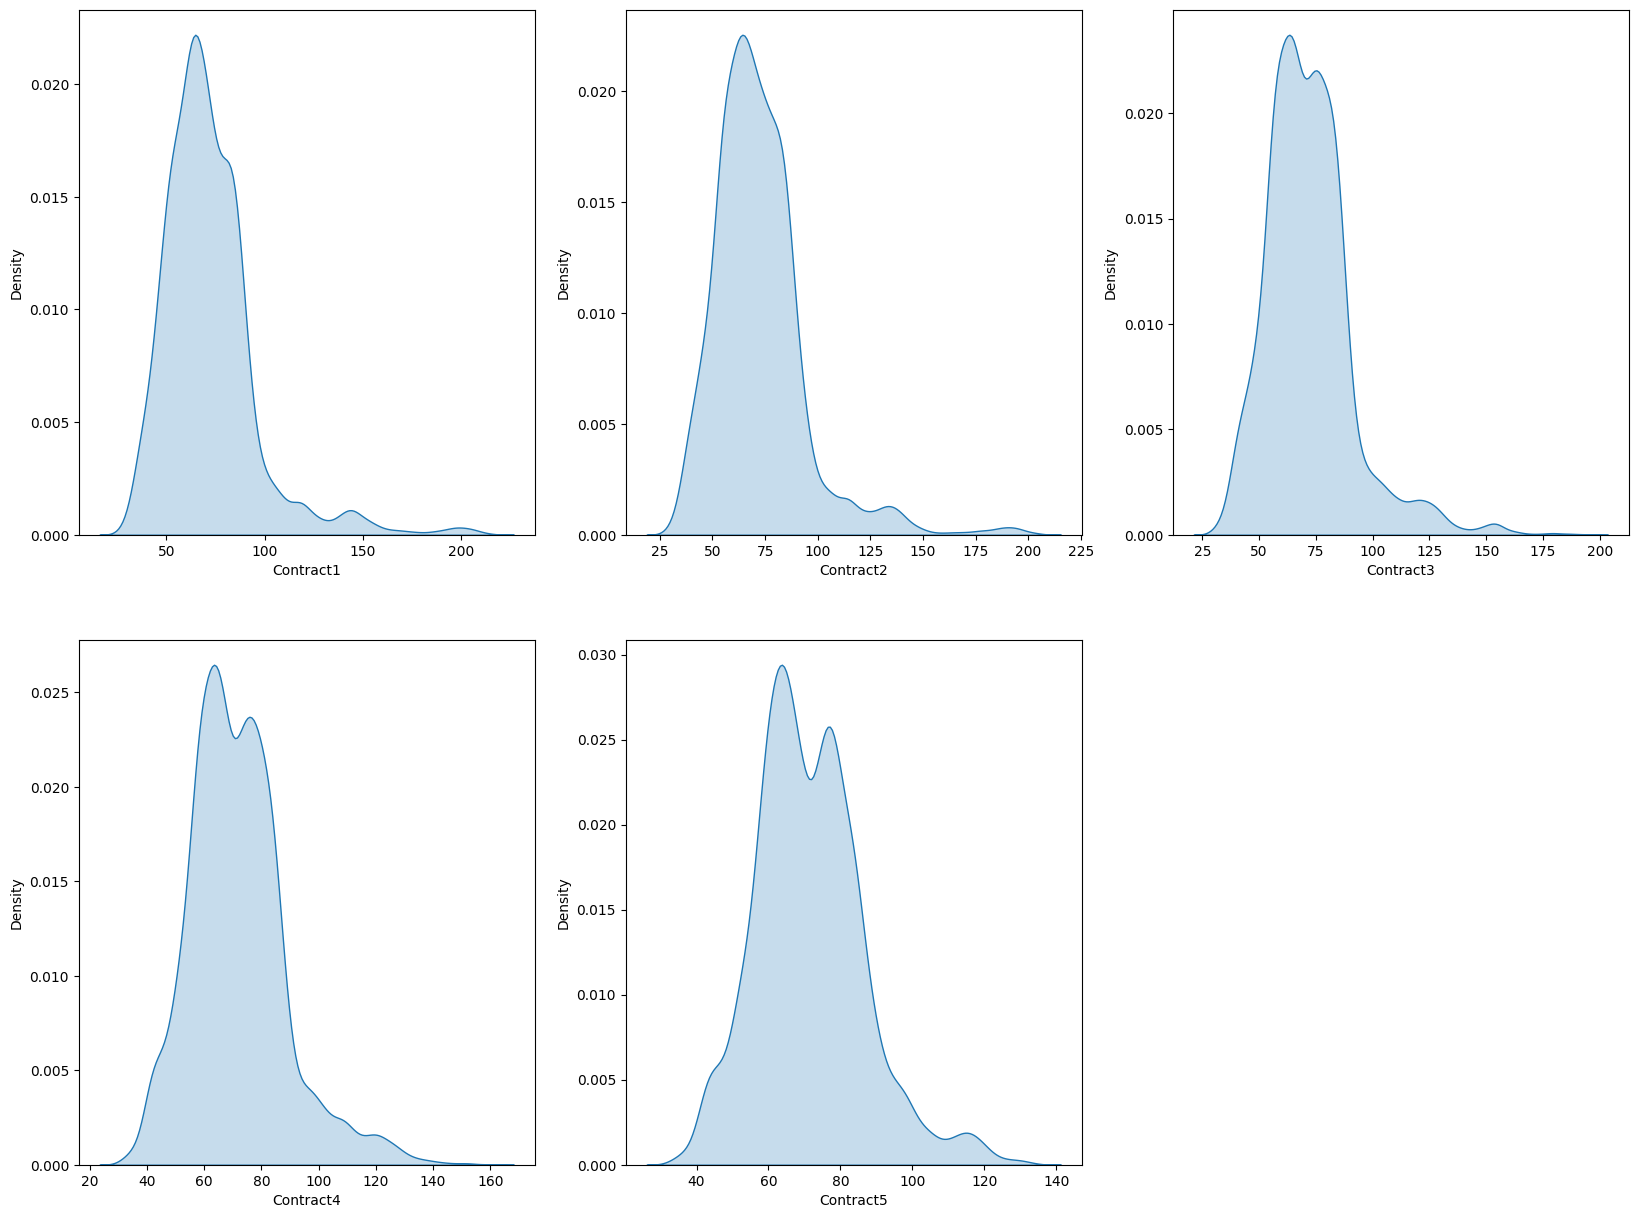

In [ ]:
fig,ax = plt.subplots(2,3, figsize=(20,15))
fig.delaxes(ax[1,2])

sns.kdeplot(ts['Contract1'], fill=True,ax=ax[0,0])
sns.kdeplot(ts['Contract2'], fill=True,ax=ax[0,1])
sns.kdeplot(ts['Contract3'], fill=True,ax=ax[0,2])
sns.kdeplot(ts['Contract4'], fill=True,ax=ax[1,0])
sns.kdeplot(ts['Contract5'], fill=True,ax=ax[1,1])

# Volatility over time and features

We observe a strong relationship between the prices of all contracts over time, with movements that follow the same overall trends. This consistent motion across contracts suggests they are closely linked, likely influenced by the same underlying market forces.

## Predictability of Changes:
When the price of one contract changes, we can predict with high confidence that other contracts will exhibit similar polarity in their movements. This correlation is particularly useful in forecasting, as observing a trend in one contract.

## Interpretation of Contracts:
These contracts likely represent the same commodity, differing only in their time to maturity. This explains their shared behavior, as they respond to the same market conditions. The variation in time to maturity, however, introduces some differences in volatility and sensitivity to market changes.

## Useful Features Constructed from Relationships Between the Contracts:
A key feature that can explain the changes in all five contracts is the daily return of the first contract. This is because the first contract is the most volatile among all contracts, making it highly sensitive to market changes. By focusing on its daily return, we capture the most dynamic movements in the market, which are likely to influence the other contracts as well.




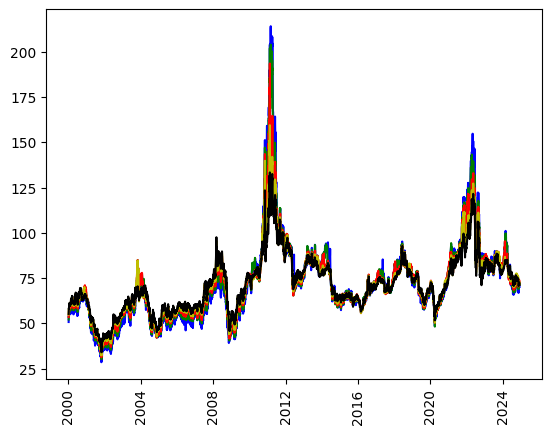

In [ ]:
plt.plot(ts['Date'], ts['Contract1'], color='b')
plt.tick_params(axis='x', rotation=90)

plt.plot(ts['Date'], ts['Contract2'], color='g')
plt.tick_params(axis='x', rotation=90)

plt.plot(ts['Date'], ts['Contract3'], color='r')
plt.tick_params(axis='x', rotation=90)

plt.plot(ts['Date'], ts['Contract4'], color='y')
plt.tick_params(axis='x', rotation=90)

plt.plot(ts['Date'], ts['Contract5'], color='black')
plt.tick_params(axis='x', rotation=90)

# Correlation between contracts

Below is the correlation matrix, which highlights the relationships between the contracts. Notably, the correlation between the 1st and 2nd contracts is $1$, indicating a perfect linear relationship. Additionally, we observe that the closer the contract numbers are to each other, the stronger their correlation.

Even the lowest correlation in the matrix is $0.94$, which confirms a strong linear relationship across all contracts. This high level of correlation suggests that these contracts are tightly linked, likely due to being based on the same underlying commodity.

It is also important to note that as the contract number increases, so does the time to maturity, reflecting the structural difference between the contracts.



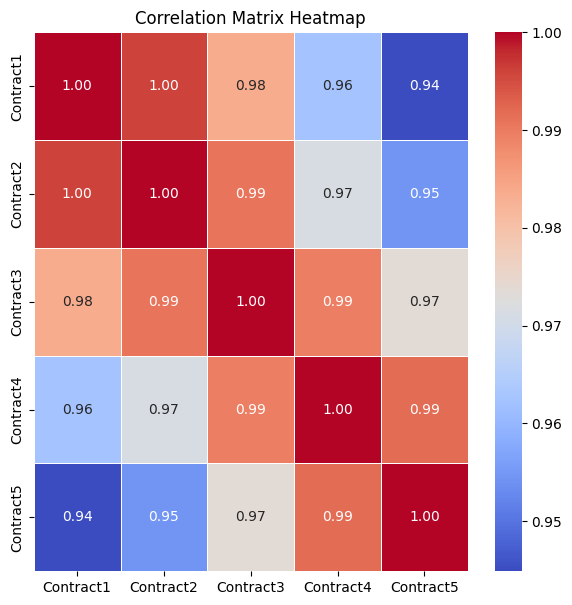

In [ ]:
correlation_matrix = ts[['Contract1', 'Contract2', 'Contract3', 'Contract4','Contract5']].corr()
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix,annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


# Analyzing the Distribution of Daily Returns

In this section, we focus on the distribution of relative daily returns. The density suggests that the distribution is approximately symmetric, which makes it reasonable to approximate it with a normal distribution. However, upon closer examination, we observe key deviations from normality.

One important difference is the kurtosis of the distribution, which is higher than that of a normal distribution with the same mean and variance. This indicates that the data is more concentrated around the mean, with a greater frequency of extreme values in the tails.

We can also observe the fat-tail problem, where the actual distribution has fatter tails compared to the normal distribution. This means that extreme events, such as large daily gains or losses, are more likely to occur than what would be expected under a normal distribution.

Understanding these characteristics is crucial for accurately modeling risk, as the presence of fat tails suggests that traditional models assuming normality may underestimate the probability of extreme outcomes.



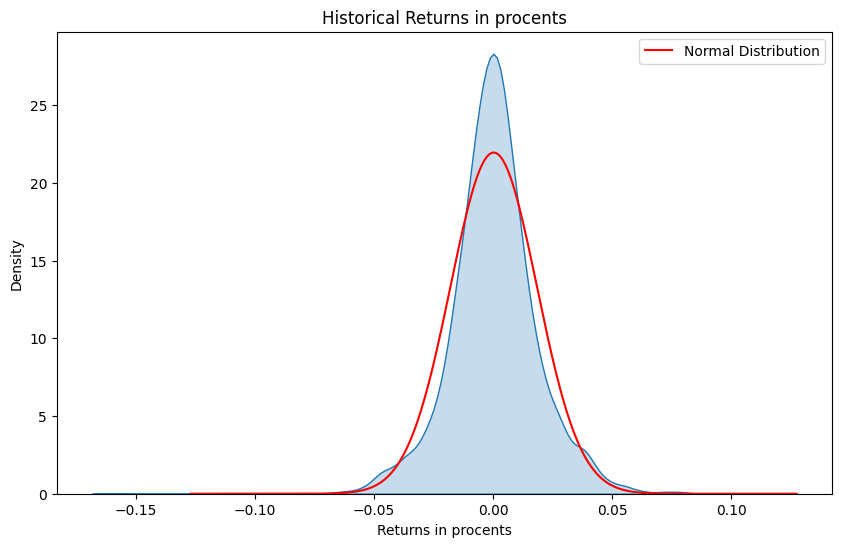

In [ ]:
mu, sigma = ts['DailyReturn'].mean(), ts['DailyReturn'].std()  # mean and standard deviation
x = np.linspace(mu - 7*sigma, mu + 7*sigma, 2000)
y = (1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2)))



plt.figure(figsize=(10, 6))
sns.kdeplot(ts['DailyReturn'], fill=True)
plt.plot(x, y, label='Normal Distribution', color = 'r')
plt.title('Historical Returns in procents')
plt.xlabel('Returns in procents')
plt.ylabel('Density')
plt.legend()
plt.show()

# Seasonality Analysis of Daily Returns

To analyze seasonality, I created two visualizations: one showing how median daily returns are distributed by month and another illustrating the distribution across days of the week. These plots reveal significant differences in daily returns based on both day of the week and month, indicating strong seasonality in the data.

I think it will be good idea of using this two features in our model. By those reasons :

Firsty, the observed variations in daily returns across days and months suggest that these time-based features encode valuable information. By incorporating month and day of the week as features, the model can better capture predictable seasonal patterns

Secondly, Since certain days of the week or months exhibit consistently higher or lower returns, these features can help the model identify and anticipate these trends. This can lead to more accurate predictions of price changes and risk metrics.

Finally, in commodity markets, day-of-the-week and monthly effects are well-documented phenomena. Including these features improving its robustness and reliability.


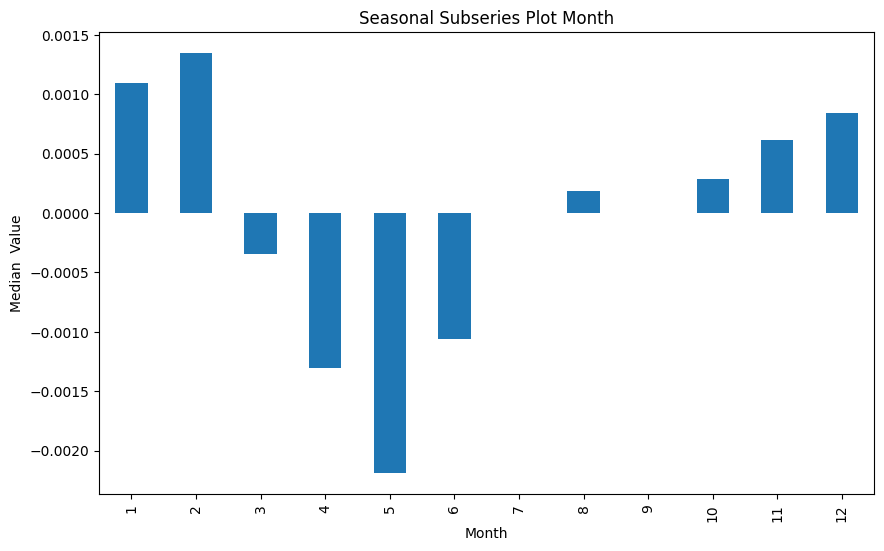

In [ ]:
ts_monthly = ts['DailyReturn'].groupby(ts['Month']).median()

ts_monthly.plot(kind="bar", figsize=(10, 6), title="Seasonal Subseries Plot Month")
plt.xlabel("Month")
plt.ylabel("Median  Value")
plt.show()


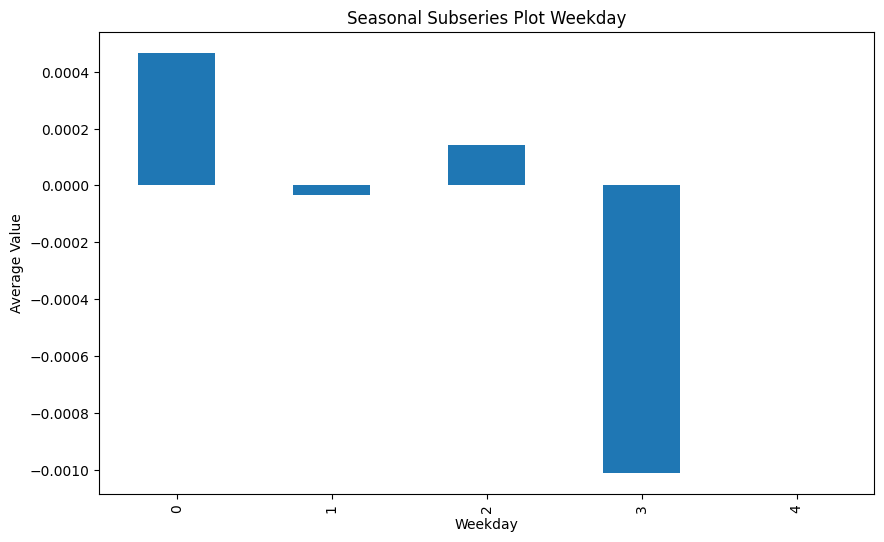

In [ ]:
ts_monthly = ts['DailyReturn'].groupby(ts['Weekday']).median()

ts_monthly.plot(kind="bar", figsize=(10, 6), title="Seasonal Subseries Plot Weekday")
plt.xlabel("Weekday")
plt.ylabel("Average Value")
plt.show()

# Time series aproach  for forecasting

The plot illustrates the distribution of daily returns over time. There is no observable trend or seasonal pattern to model as a time series. However, the series appears to be stationary, which supports the assumption needed for applying ARIMA or SARIMA models.



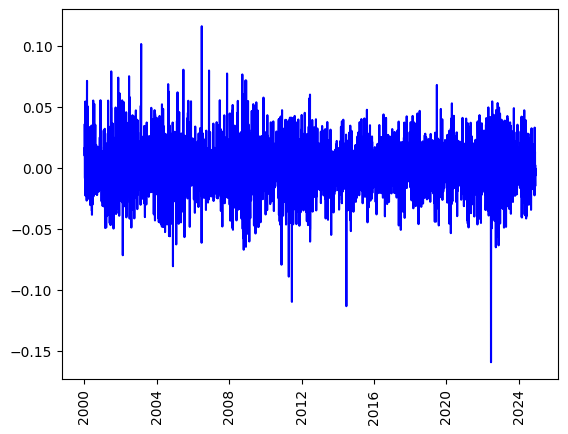

In [ ]:
plt.plot(ts['Date'], ts['DailyReturn'], color = 'b')
plt.tick_params(axis='x', rotation=90)



## Stationarity ADF-test

Based on ADF test we can reject the null-hyposeses and conclude that our time series is stationary on $1$% significance level.

In [ ]:
adf_result = adfuller(ts['DailyReturn'].dropna())

adf_result

(-55.598140065807165,
 0.0,
 1,
 6252,
 {'1%': -3.431396383066701,
  '5%': -2.8620024085488898,
  '10%': -2.5670161371235163},
 -32225.61664521825)

## Autocorrelation analysis

The ACF and PACF graphs show the correlation of our data at time
$t$ with time $t -k$. For $k=25$, we observe no significant autocorrelation or partial autocorrelation in daily returns. This suggests that the ARIMA model may not perform well, as these models rely on autocorrelation to explain the series based on previous observations and white noise.

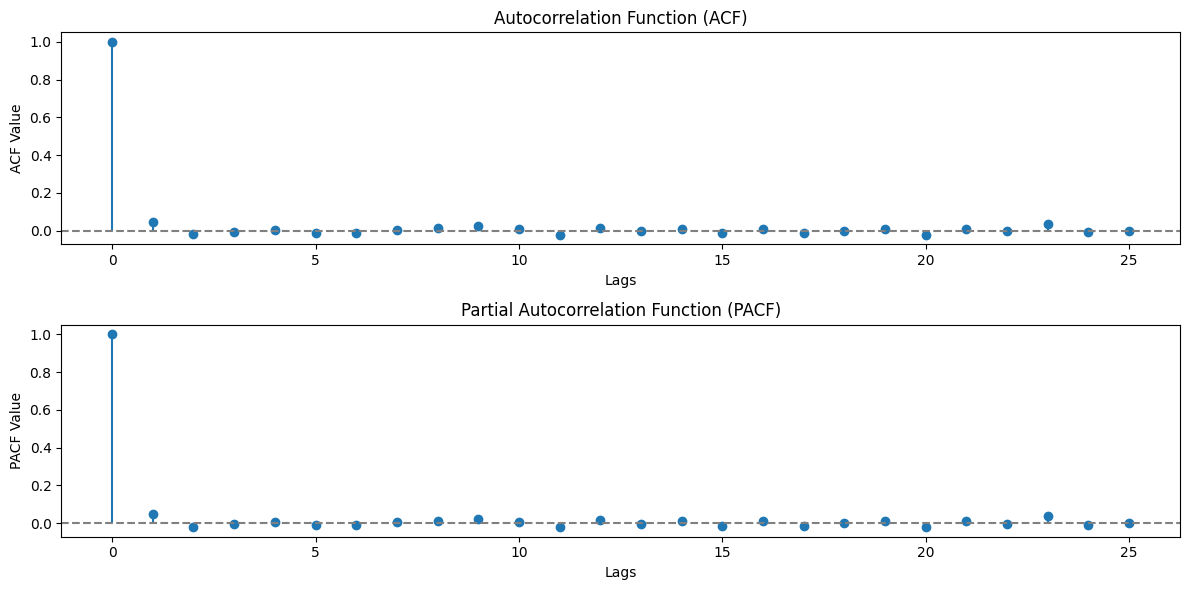

In [ ]:

# Example time series
ts1 = ts['DailyReturn'].dropna()

# Calculate ACF and PACF
lags = 25
acf_values = acf(ts1, nlags=lags)
pacf_values = pacf(ts1, nlags=lags)

# Plot ACF
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.stem(range(lags + 1), acf_values, basefmt=" ")
plt.axhline(0, linestyle='--', color='gray')
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lags")
plt.ylabel("ACF Value")

# Plot PACF
plt.subplot(2, 1, 2)
plt.stem(range(lags + 1), pacf_values, basefmt=" ")
plt.axhline(0, linestyle='--', color='gray')
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lags")
plt.ylabel("PACF Value")

plt.tight_layout()
plt.show()


# Adding features for modeling

First, I would like to mention that I will use a classification approach for prediction. The target variable in this case will be binary: it will take the value of $1$ when the price is equal to or less than $0$ and $0$ otherwise.

To improve the model, I will incorporate additional variables to support better decision-making. However, it is crucial to ensure that these added variables do not inadvertently leak information about the target variable. Specifically, for any observation at time $t$, we must avoid including variables that provide direct information about the target at time $t$.

For example, I used a 5-day moving average as a feature. If I included this moving average without any lag, it would create a data leakage issue because the target variable would then have information about itself, leading to incorrect results. To address this, I applied the shift function. By doing so, the moving average at time $t-5$ is used for the observation at time $t$. The choice of $5$ days is informed by the seasonality in the data.

Another variable I included is the target value from the previous week because historical patterns or dependencies in the data can help improve the model's ability to predict future outcomes.

In [ ]:
ts['Target'] = np.where(ts['DailyReturn'] <= 0, 1, 0)
ts['MA_5'] = ts['DailyReturn'].shift(5).rolling(window=5).mean()

ts['Lag'] = np.where(ts['DailyReturn'].shift(5) <= 0, 1, 0)


ts.dropna().head()

,Date,Year,Month,Weekday,DailyReturn,Contract1,Contract2,Contract3,Contract4,Contract5,Target,MA_5,Lag
10,2000-01-19,2000,1,2,0.054602,57.75,59.03,60.10,61.00,61.20,0,0.013342,0
11,2000-01-20,2000,1,3,-0.005368,57.44,58.76,59.78,60.65,61.00,1,0.008371,1
12,2000-01-21,2000,1,4,-0.022458,56.15,57.38,58.35,59.35,59.66,1,0.010189,0
13,2000-01-24,2000,1,0,0.003562,56.35,57.56,58.57,59.30,59.65,0,0.004321,0
14,2000-01-25,2000,1,1,0.026797,57.86,58.93,59.83,60.50,60.94,0,0.004497,1


# Modeling and Splitting the Dataset into Train and Test Sets

In this section, we first divide the dataset into training and testing sets. Since we are working with time series data, it is important to avoid randomly selecting $10$% of the data for testing, as this approach ignores the sequential nature of time series. Instead, I follow a classic time series approach by using the first $90$% of the observations for training and reserving the remaining $10$% for evaluation.

For the classification of the target variable, I have chosen to use the Random Forest algorithm. This method is more suitable than classic time series models for several reasons. First, traditional time series approaches failed to provide realistic predictions, especially in estimating variability. Additionally, these approaches are limited to predicting only a few steps ahead, whereas our task requires predictions for $632$ steps.

## Why Random Forest is a Better Option

1. *The ability to use multiple predictors:* Unlike many traditional time series models, Random Forest allows for the inclusion of multiple variables as predictors, which can help explain more variability.

2. *Accounting for non-linear relationships:* Random Forest is based on decision trees, which are capable of modeling non-linear relationships between variables.

3. *Reduced risk of overfitting:* Random Forest combines predictions from multiple decision trees in an ensemble approach, generating 150 trees in our case. This comprehensive method ensures reliability and reduces the risk of retraining.

By utilizing these advantages, Random Forest offers a more accurate and reliable grading of the target variable when compared to traditional time series methods.




In [ ]:
train_size = int(len(ts) * 0.9)
X_train = ts[['Lag','Weekday', 'Month']][:train_size]

y_train = ts['Target'][:train_size]

X_test = ts[[ 'Lag','Weekday', 'Month']][train_size:]

y_test = ts['Target'][train_size:]

rf = RandomForestRegressor(n_estimators= 150, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

# Evaluation of model


## ROC and AUC
The Receiver Operating Characteristic (ROC) curve is a commonly used tool for evaluating the classification ability of binary classifiers. The Area Under the Curve (AUC) score is one of the best metrics for this purpose, as it summarizes the trade-off between sensitivity (true positive rate) and 1-specificity (false positive rate) across different threshold values.

In the provided ROC curve, the AUC score is $0.452$, and the curve lies below the diagonal line, which might initially appear worse than a random classifier with an AUC of $0.5$. However, this is a misconception. The position of the curve—whether it is above or below the diagonal—is not inherently indicative of the model's quality.

If the curve is below the diagonal, it simply suggests that the classifier is making systematic errors in its predictions, effectively misclassifying the classes. This can be corrected by flipping the predictions: changing the class labels such that $0$ becomes $1$ and $1$ becomes $0$. After this adjustment, the AUC score would become $1 - 0.452 = 0.548$, which indicates that the model performs slightly better than random guessing.

The fact that the curve lies below the diagonal highlights the need to carefully interpret the classifier's output and thresholds. By addressing such issues, the model's performance can be evaluated more accurately, and appropriate adjustments can improve its utility.



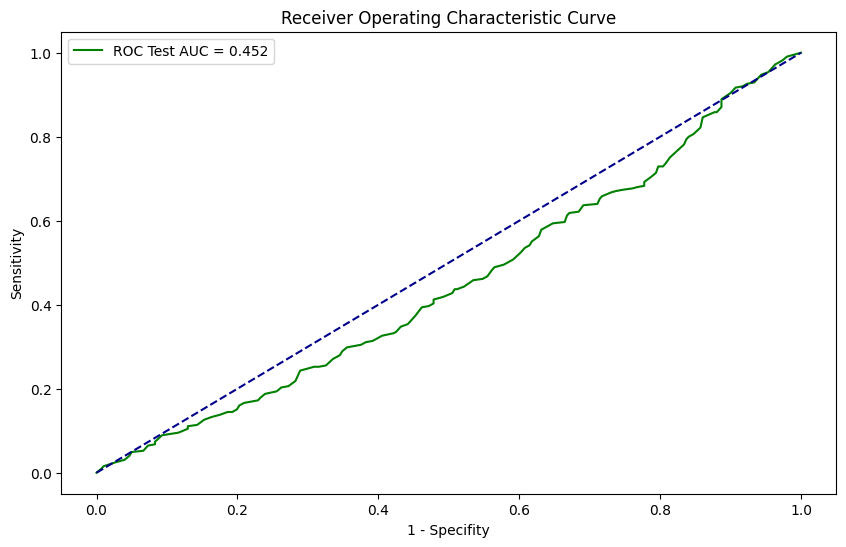

In [ ]:
from sklearn.metrics import roc_auc_score


y_pred = rf.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test,y_pred)

auc = roc_auc_score(y_test, y_pred)

y_pred = rf.predict(X_test)

fpr, tpr, threshold = roc_curve(y_test,y_pred)

auc = round(roc_auc_score(y_test, y_pred),3)


#Plotting the figure
plt.figure(figsize = (10,6))
plt.plot(fpr,tpr, color='green', label='ROC Test AUC = {}'.format(auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('1 - Specifity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()


### Threshold Determination and Model Evaluation

The threshold for classification was determined by maximizing the Youden index, which is the difference between the True Positive Rate (TPR) and the False Positive Rate (FPR). This method was applied to the training data to avoid introducing bias into the evaluation process. It is crucial to avoid calculating the threshold on the test data, as doing so could lead to overly optimistic performance metrics.

In this model, the classification is done inversely: if the probability of belonging to the positive class is less than the threshold, the object is classified as $0$ (Up); otherwise, it is classified as $1$ (Down). The threshold value that maximized the difference between TPR and FPR was identified as the optimal threshold for the model.

## Confusion Matrix Evaluation

The confusion matrix is another method used to evaluate the model. It compares the actual values with the predicted values and provides insights into the classification performance. In this case, there are four possible outcomes:

* True Positive (TP): Correctly predicting an increase in price

* True Negative (TN): Correctly predicting a decrease in price.

* False Positive (FP): Predicting an increase in price when the actual outcome was a decrease.

* False Negative (FN): Predicting a decrease in price when the actual outcome was an increase.

Based on the confusion matrix:

1. The model correctly classified $165$ cases of price increases (TP).
2. The model correctly classified $175$ cases of price decreases (TN).
3. The model incorrectly classified $136$ cases where it predicted an increase but the actual outcome was a decrease (FP).
4. The model incorrectly classified $150$ cases where it predicted a decrease but the actual outcome was an increase (FN).

The model does not perform exceptionally well based on the confusion matrix, as it makes a significant number of ambiguous errors. **However, in the context of a trading strategy, this may not be as critical. The key factor in trading is ensuring that the number of correct transactions exceeds the number of incorrect ones, as this is essential for achieving profitability.**

In this case, the model demonstrates this capability: the number of correct classifications (340) exceeds the number of incorrect ones (286). This suggests that the model has the potential to support a profitable trading strategy, even if its overall performance could be better.



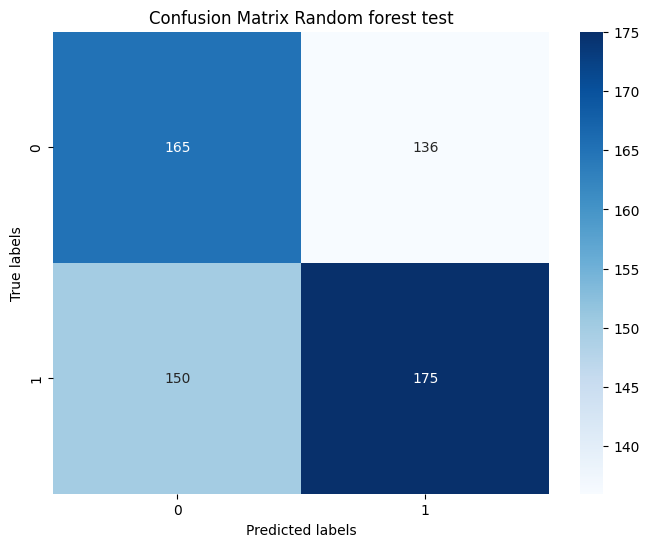

In [ ]:
y_pred_t = rf.predict(X_train)


fpr_t, tpr_t, threshold_t = roc_curve(y_train, y_pred_t)

optimal_idx_t = np.argmax(tpr_t - fpr_t)

optimum_t = threshold_t[optimal_idx_t]

y_pred_actual = (y_pred < optimum_t)

cm_t = confusion_matrix(y_test, y_pred_actual)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_t, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Random forest test')
plt.show()


## Metrics Based on Confusion Matrix


We can see that the accuracy of our model is $54$%. This means that we correctly classify $54$% of our objects. For a trading strategy, I think this level of accuracy is enough to make a profit since we are correct in more than half of the cases in long run.

Precision shows how many predicted increases were actually increases. We can see that precision is $56$%, which is more than $50$%. This indicates that this strategy could generate profit.

Recall, also known as sensitivity, is the ratio of correctly predicted increases to all actual increases. It shows how many of the predicted values were correct. In this case, recall is $54$%.

I think the model does not perform very well overall, but on the test set, it shows it can perform at least to some extent and has the potential to generate profit.



In [ ]:


def binary_classification_metrics(y_true, y_pred):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)

    return metrics


metrics = binary_classification_metrics(y_test, y_pred_actual, y_pred)
metrics

{'accuracy': 0.5431309904153354,
 'precision': 0.5627009646302251,
 'recall': 0.5384615384615384,
 'f1_score': 0.550314465408805,
 'roc_auc': 0.45194479938665977}

# The maximum drawdown of the model

To evaluate the performance of our trading strategy, we calculate the maximum drawdown (MDD), which measures the largest decline in portfolio value from a peak to a trough during a specific period. This is a critical metric for assessing the risk and volatility of the model's predictions.

The trading strategy implemented here is simple. A position is opened only when the model predicts a $0$ (indicating a decrease in price). If the prediction is $1$, no trades are made. The strategy assumes that contracts are bought the day before and sold the next day, and the returns are added to the portfolio only on days with a $0$ prediction. The cumulative portfolio value is then tracked over time, starting with an initial value of $1$.

The calculated maximum drawdown is $0.74$, meaning the portfolio value dropped by $74$% from its highest peak before recovering. This sharp decline occurred in July 2022, a period marked by significant global instability due to the ongoing war in Ukraine. The conflict has had a profound impact on global financial markets, causing increased volatility, disrupted supply chains, and heightened uncertainty. These factors likely contributed to the steep drawdown, as markets were highly reactive and unpredictable during this time.








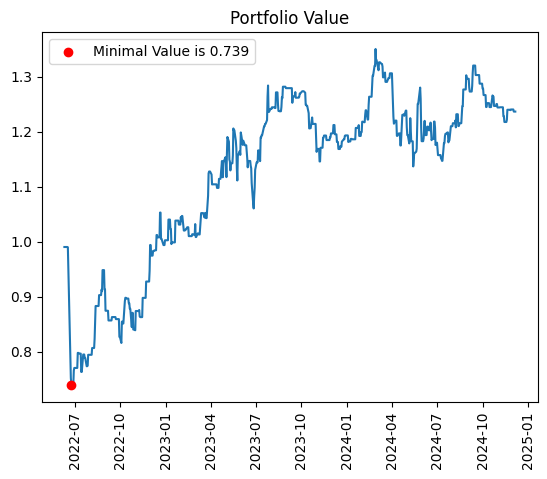

In [ ]:
ts['Prediction'] = 0

ts['Prediction'][train_size:] = y_pred_actual

ts['Strategy_Return'] = np.where(ts['Prediction'] == 0, ts['DailyReturn'], 0)

initial_value = 1

ts['Portfolio_Value'] = 0
ts['Portfolio_Value'][train_size:] = initial_value * (1 + ts['Strategy_Return'][train_size:]).cumprod()




plt.plot(ts['Date'][train_size:], ts['Portfolio_Value'][train_size:])

# Find the index of the minimal value
min_index = ts['Portfolio_Value'][train_size:].idxmin()

# Get the minimal value and corresponding date
min_value = ts['Portfolio_Value'][min_index]
min_date = ts['Date'][min_index]

# Add a red dot at the minimal value
plt.scatter(min_date, min_value, color='red',
            label='Minimal Value is {}'.format(round(min_value,3)), zorder=5)
plt.title('Portfolio Value')
# Rotate x-axis labels
plt.tick_params(axis='x', rotation=90)
plt.legend()
# Show the plot
plt.show()

# Sharpe ratio

A Sharpe ratio of 0.482 indicates that the investment's return is half the level of its volatility or risk. This reflects a relatively low risk-adjusted return, which might appeal to conservative investors seeking modest returns with manageable risk.







In [ ]:
mean_yearly_return = ts['Strategy_Return'][train_size:].mean()*252

volatility_yearly_return = ts['Strategy_Return'][train_size:].std()*np.sqrt(252)

sharpe_ratio = mean_yearly_return / volatility_yearly_return

print("Sharpe Ratio equals {}".format(round(sharpe_ratio,3)))



Sharpe Ratio equals 0.482
